In [1]:
#Eric Tang
#SS 3850  Statistical Learning

#Goal: Predict the sign of SPY's next day pct return (open to close)

# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import sys
import seaborn as sns

import quandl

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn import metrics


# Classifiers
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier


In [2]:
quandl.ApiConfig.api_key = "WLMxat9y7vVtegz9ZEe5"
start = '2000-01-01'
end = '2020-02-20'

np.random.seed(seed=1)

C:\Users\yizho\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


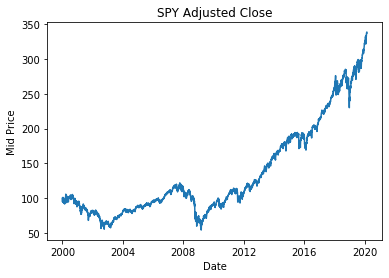

In [3]:
## Initialization

# Import SPY
df = pd.read_csv('SPY.csv',index_col = 'Date',parse_dates = True)

#Visualization
plt.figure()
plt.title("SPY Adjusted Close")
plt.plot(df['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.show()


#Shift -1 for next day's return
#Classification
df['next_day_SPY_openclose_ret'] = df['Close'].shift(-1)/df['Open'].shift(-1) -1

#If tomorrow's return >= 0, then 1
#If tomorrow's return < 0, then -1
df['y'] = 1 #Initialize
df.at[df['next_day_SPY_openclose_ret'] >= 0,'y'] = 1
df.at[df['next_day_SPY_openclose_ret'] < 0,'y'] = -1

#Remove it make sure no look ahead bias
del df['next_day_SPY_openclose_ret']


In [4]:
## Importing Daily Data from Quandl

#Get relevant daily data from Quandl
#Macro features
quandl_dict= {
    #futures
    'gold' :"CHRIS/CME_GC1.4", #Gold Futures, Continuous Contract #1 (GC1) (Front Month)
    'eurodollar': "CHRIS/CME_ED1.4", #Eurodollar Futures, Continuous Contract #1 (ED1) (Front Month)
    'silver': "CHRIS/CME_SI1.4", #Silver Futures, Continuous Contract #1 (SI1) (Front Month)
    'DCOILWTICO': "FRED/DCOILWTICO.4", #Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma
    #major currency pair spot rates
    'USDCAD': "FED/RXI_N_B_CA", #CANADA -- SPOT EXCHANGE RATE, CANADIAN $/US$, Business day
    'EURUSD': "FED/RXI_US_N_B_EU", #SPOT EXCHANGE RATE - EURO AREA, Business day
    'GBPUSD': "FED/RXI_US_N_B_UK", #UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK), Business day
    'USDJPY': "FED/RXI_N_B_JA", #JAPAN -- SPOT EXCHANGE RATE, YEN/US$, Business day
    'AUDUSD': "FED/RXI_US_N_B_AL", #AUSTRALIA -- SPOT EXCHANGE RATE US$/AU$ (RECIPROCAL OF RXI_N.B.AL), Business day
    'NZDUSD': "FED/RXI_US_N_B_NZ", #NEW ZEALAND -- SPOT EXCHANGE RATE, US$/NZ$ RECIPROCAL OF RXI_N.B.NZ, Business day
    'USDCHF': "FED/RXI_N_B_SZ", #SWITZERLAND -- SPOT EXCHANGE RATE, FRANCS/US$, Business day
    'USDNOK': "FED/RXI_N_B_NO", #NORWAY -- SPOT EXCHANGE RATE, KRONER/US$, Business day
    'USDCNY': "FED/RXI_N_B_CH", #CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R., Business day
    'USDINR': "FED/RXI_N_B_IN", #INDIA -- SPOT EXCHANGE RATE, RUPEES/US$, Business day
    'DTWEXM': "FRED/DTWEXM", #Trade Weighted U.S. Dollar Index: Major Currencies
    'DTWEXB': "FRED/DTWEXB", #Trade Weighted U.S. Dollar Index: Broad
    #Interest rates
    'DFF': "FRED/DFF", #Effective Federal Funds Rate
    'DTB3': "FRED/DTB3", #3-Month Treasury Bill: Secondary Market Rate
    'DGS5': "FRED/DGS5", #5-Year Treasury Constant Maturity Rate
    'DGS10': "FRED/DGS10",#10-Year Treasury Constant Maturity Rate
    'DGS30': "FRED/DGS30", #30-Year Treasury Constant Maturity Rate
    'T5YIE': "FRED/T5YIE", #5-year Breakeven Inflation Rate
    'T10YIE': "FRED/T10YIE", #10-year Breakeven Inflation Rate
    'T5YIFR': "FRED/T5YIFR",#5-Year, 5-Year Forward Inflation Expectation Rate 
    'TEDRATE': "FRED/TEDRATE", #TED Spread
    'DPRIME': "FRED/DPRIME" #Bank Prime Loan Rate

}

#Function to get data from Quandl.

def get_quandl_data(df,quandl_dict,start,end):
    #Iterate through the dictionary of quandl tickers
    for i in quandl_dict:
        quandlCode = quandl_dict[i]
        #retrieve data from quandl API
        df_temp = quandl.get(quandlCode)
        #Rename column
        df_temp.columns = [i]
        #concat input dataframe and the new data
        df = pd.concat([df, df_temp.reindex(df.index)], axis=1)
    #Trim data 
    mask = (df.index>=pd.to_datetime(start)) & (df.index <=pd.to_datetime(end))
    df = df.loc[mask]
    return df

df = get_quandl_data(df,quandl_dict,start,end)

In [5]:
## Importing Local Files

#Get relevant local files (Source: yahoo finance)
local_files = [
    'VIX', #Vix index
    #Sector ETFs:
    'XLE', #Energy Select Sector SPDR Fund 
    'XLF', #Financial Select Sector SPDR Fund
    'XLU', #Utilities Select Sector SPDR Fund
    'XLI', #Industrial Select Sector SPDR Fund
    'XLK', #Technology Select Sector SPDR Fund
    'XLV', #Health Care Select Sector SPDR Fund
    'XLY', #Consumer Discretionary Select Sector SPDR Fund
    'XLP', #Consumer Staples Select Sector SPDR Fund
    'XLB', #Materials Select Sector SPDR Fund
    ]


#Function to get data from Quandl.
def get_local_data(df,local_files,start,end):
    for i in local_files:
        fileName = i + '.csv'
        df_temp = pd.read_csv(fileName,index_col='Date',parse_dates = True)#Vix index
        df_temp = df_temp['Adj Close'].to_frame()
        df_temp.columns = [i]
        df = pd.concat([df, df_temp.reindex(df.index)], axis=1)

    mask = (df.index>=pd.to_datetime(start)) & (df.index <=pd.to_datetime(end))
    df = df.loc[mask]
    return df


#Get local data
df = get_local_data(df,local_files,start,end)


In [6]:
## Feature Engineering 

#Compute additional derived features

#Pct diff between adj close & EW moving averages
def compute_EWMA(df,N):
    EWMA =  pd.DataFrame.ewm(df['Adj Close'], span=N).mean()
    df['EWMA'+str(N)+'_pct_diff'] = df['Adj Close'] / EWMA
    return df


#Function to compute indicators
def get_indicators_daily(df,col):
    df[col+'_ret'] = df[col].pct_change()
    df[col+'_diff'] = df[col].diff()
    
    df[col+'_rolling_mean_21'] = df[col+'_ret'].rolling(21).mean()
    df[col+'_rolling_stdev_21'] = df[col+'_ret'].rolling(21).std()#1 month rolling stdev 
    df[col+ '_rolling_skew_21'] = df[col+'_ret'].rolling(21).skew()
    df[col+ '_rolling_kurt_21'] = df[col+'_ret'].rolling(21).kurt()
    
    df[col+'_rolling_mean_63'] = df[col+'_ret'].rolling(63).mean()
    df[col+'_rolling_stdev_63'] = df[col+'_ret'].rolling(63).std()#1 quarter rolling stdev 
    df[col+ '_rolling_skew_63'] = df[col+'_ret'].rolling(63).skew()
    df[col+ '_rolling_kurt_63'] = df[col+'_ret'].rolling(63).kurt()
    
    df[col+'_rolling_mean_126'] = df[col+'_ret'].rolling(126).mean()
    df[col+'_rolling_stdev_126'] = df[col+'_ret'].rolling(126).std()#6 months rolling stdev 
    df[col+ '_rolling_skew_126'] = df[col+'_ret'].rolling(126).skew()
    df[col+ '_rolling_kurt_126'] = df[col+'_ret'].rolling(126).kurt()
    
    df[col+'_rolling_mean_252'] = df[col+'_ret'].rolling(252).std()#1 yr rolling stdev 
    df[col+ '_rolling_skew_252'] = df[col+'_ret'].rolling(252).skew()
    df[col+ '_rolling_kurt_252'] = df[col+'_ret'].rolling(252).kurt()
    
    df[col+ '_ewma10'] = pd.DataFrame.ewm(df[col], span=10).mean()
    df[col+ '_ewma20'] = pd.DataFrame.ewm(df[col], span=20).mean()
    df[col+ '_ewma60'] = pd.DataFrame.ewm(df[col], span=60).mean()
    df[col+ '_ewma252'] = pd.DataFrame.ewm(df[col], span=252).mean()
    df[col+ '_ewma10_ratio'] = df[col] / df[col+ '_ewma10']
    df[col+ '_ewma20_ratio'] =  df[col] / df[col+ '_ewma20']
    df[col+ '_ewma60_ratio'] =  df[col] / df[col+ '_ewma60']
    df[col+ '_ewma252_ratio'] =  df[col] / df[col+ '_ewma252']
    
    #MACD histogram
    slow = pd.DataFrame.ewm(df[col], span=12).mean()
    fast = pd.DataFrame.ewm(df[col], span=26).mean()
    macd = fast - slow
    macd_signal = pd.DataFrame.ewm(macd, span=9).mean()
    df[col+'_MACD_hist'] = macd - macd_signal
    
    return df


#Compute derived features
features = df.columns
for i in features:
    if i != 'y':
        df = get_indicators_daily(df,i)

In [7]:
## Importing economic data from Quandl

#econ features that are not daily (weekly, monthly & quarterly data - need to ffill)
#Due to the low frequency factor, additional derived features are not computed

sparse_econ_data= {
    #Growth
    'GDP' :"FRED/GDPPOT", #Gross Domestic Product
    'GDPC1': "FRED/GDPC1", #Real Gross Domestic Product
    'GDPPOT': "FRED/GDPC1", #Real Potential Gross Domestic Product
    #Prices and Inflation
    'CPIAUCSL': "FRED/CPIAUCSL", #Consumer Price Index for All Urban Consumers: All Items
    'CPILFESL': "FRED/CPILFESL", #Consumer Price Index for All Urban Consumers: All Items Less Food & Energy
    'GDPDEF': "FRED/GDPDEF", #Gross Domestic Product: Implicit Price Deflator
    #Money Supply
    'BASE': "FRED/BASE", #St. Louis Adjusted Monetary Base
    'M1': "FRED/M1", #M1 Money Stock
    'M2': "FRED/M2", #M2 Money Stock
    'M1V': "FRED/M1V", #Velocity of M1 Money Stock
    'M2V': "FRED/M2V", #Velocity of M2 Money Stock
    #Employment
    'UNRATE': "FRED/UNRATE", #Civilian Unemployment Rate
    'NROU': "FRED/NROU", #Natural Rate of Unemployment (Long-Term)
    'NROUST': "FRED/NROUST", #Natural Rate of Unemployment (Short-Term)
    'CIVPART': "FRED/CIVPART", #Civilian Labor Force Participation Rate
    'EMRATIO': "FRED/EMRATIO", #Civilian Employment-Population Ratio
    'UNEMPLOY': "FRED/UNEMPLOY", #Unemployed level
    'PAYEMS': "FRED/PAYEMS", #All Employees: Total nonfarm
    'MANEMP': "FRED/MANEMP", #All Employees: Manufacturing
    'ICSA': "FRED/ICSA", #Initial Claims
    #Income and Expenditure
    'MEHOINUSA672N': "FRED/MEHOINUSA672N", #Real Median Household Income in the United States
    'DSPIC96': "FRED/DSPIC96", #Real Disposable Personal Income
    'PCE': "FRED/PCE", #Personal Consumption Expenditures
    'PCEDG': "FRED/PCEDG", #Personal Consumption Expenditures: Durable Goods
    'PSAVERT': "FRED/PSAVERT", #Personal Saving Rate
    'RRSFS': "FRED/RRSFS", #Real Retail and Food Services Sales
    'DSPI': "FRED/DSPI", #Disposable personal income
    #Debt
    'GFDEBTN': "FRED/GFDEBTN", #Federal Debt: Total Public Debt
    'GFDEGDQ188S': "FRED/GFDEGDQ188S", #Federal Debt: Total Public Debt as Percent of Gross Domestic Product
    'EXCSRESNW': "FRED/EXCSRESNW", #Excess Reserves of Depository Institutions
    'TOTCI': "FRED/TOTCI", #Commercial and Industrial Loans, All Commercial Banks
    #Other Economic Indicators
    'INDPRO': "FRED/INDPRO", #Industrial Production Index
    'TCU': "FRED/TCU", #Capacity Utilization: Total Industry
    'HOUST': "FRED/HOUST", #Housing Starts: Total: New Privately Owned Housing Units Started
    'GPDI': "FRED/GPDI", #Gross Private Domestic Investment
    'CP': "FRED/CP", #Corporate Profits After Tax (without IVA and CCAdj)
    'STLFSI': "FRED/STLFSI", #St. Louis Fed Financial Stress Index
    'USSLIND': "FRED/USSLIND", #Leading Index for the United States
}

#Function to get sparse econ data (frequence != daily) from Quandl.
#Also compute ret
#Ffill
def get_sparse_econ_data(df,econ_dict,start,end):
    originalIdx = df.index
    for i in econ_dict:
        quandlCode = econ_dict[i]
        df_temp = quandl.get(quandlCode)
        df_temp.columns = [i]
        df_temp[i + '_ret'] = df_temp[i]/df_temp[i].shift(1)-1
        df = pd.concat([df, df_temp], axis=1)
        df[i] = df[i].ffill()
    
    mask = (df.index>=pd.to_datetime(start)) & (df.index <=pd.to_datetime(end))
    df = df.loc[mask]
    df = df.reindex(originalIdx)
    return df


df = get_sparse_econ_data(df,sparse_econ_data,start,end)

In [8]:
## Data preprocessing

#rmissingvaluecol is a helper function that removes columns that have nans more than the threshold percentage
def rmissingvaluecol(df,threshold):
    l = []
    l = list(df.drop(df.loc[:,list((100*(df.isnull().sum()/len(df.index))>=threshold))].columns, 1).columns.values)
    print("# Columns having more than %s percent missing values:"%threshold,(df.shape[1] - len(l)))
    #print("Column filtered out:\n",list(set(list((df.columns.values))) - set(l)))
    return l

df = df.replace([np.inf, -np.inf], np.nan)

cols = rmissingvaluecol(df,1) #Here threshold is 1% which means we are going to drop columns having more than 1% of missing values

df_dropped_na= df[cols]

df_dropped_na = df_dropped_na.dropna()

# Columns having more than 1 percent missing values: 627


In [9]:
## Train/Test Split

#Split data set
df_train = df_dropped_na.loc[df_dropped_na.index <=pd.to_datetime('2016-01-01')]
df_test = df_dropped_na.loc[df_dropped_na.index >pd.to_datetime('2016-01-01')]


X_train_raw = df_train.loc[:, df_train.columns != 'y']
y_train = df_train.loc[:, df_train.columns == 'y']

X_test_raw = df_test.loc[:, df_test.columns != 'y']
y_test = df_test.loc[:, df_test.columns == 'y']


Feature ranking and their importances:
1. feature gold_ret (0.003529)
2. feature DGS5_ret (0.003527)
3. feature AUDUSD_ret (0.003489)
4. feature DTWEXM_ret (0.003484)
5. feature GBPUSD_ret (0.003472)


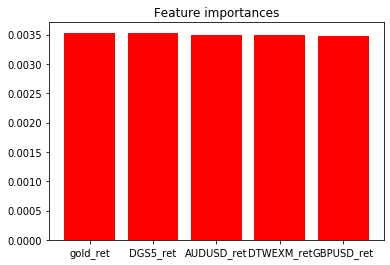

In [10]:
## Feature Selection

#Standardize -->  RFECV --> PCA

#Standardize
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train_standardized = scaler.transform(X_train_raw)
X_test_standardized = scaler.transform(X_test_raw)

#Tree-based feature selection
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest_clf = forest.fit(X_train_standardized, y_train.values.ravel())
selector = SelectFromModel(forest_clf, prefit=True)

importances = forest_clf.feature_importances_
indices = np.argsort(importances)[::-1]

top = 5
# Print the feature ranking
print("Feature ranking and their importances:")

for f in range(top):
    print("%d. feature %s (%f)" % (f + 1, X_train_raw.columns[indices[f]], importances[indices[f]]))
    
# Plot the top feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(top), importances[indices][0:top],
       color="r", align="center")
plt.xticks(range(top), X_train_raw.columns[indices[0:top]])
plt.show()

#Filter
X_train_selected = selector.transform(X_train_standardized)
X_test_selected = selector.transform(X_test_standardized)


In [11]:
## Report Feature Selection results

print("Feature Selection Summary:")
print("Raw Features")
print(X_train_raw.shape)
print("Standardized Features")
print(X_train_standardized.shape)
print("Selected Features")
print(X_train_selected.shape)



Feature Selection Summary:
Raw Features
(3931, 583)
Standardized Features
(3931, 583)
Selected Features
(3931, 309)


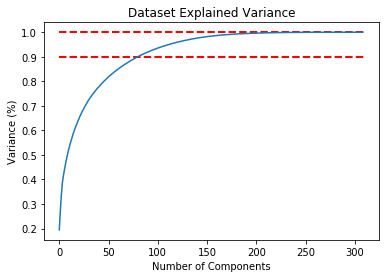

Number of components needed to explain at least 99% of the total variance
171


In [12]:
## Dimension Reduction Part 1

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train_selected)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#Horizontal lines on 100% & 90%
plt.hlines(y=1, xmin=0, xmax=X_train_selected.shape[1], colors='r', linestyles='--', lw=2)
plt.hlines(y=0.9, xmin=0, xmax=X_train_selected.shape[1], colors='r', linestyles='--', lw=2)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

#Now we search for the number of components needed for at least 90% of the variance
cumulativeVariance = np.cumsum(pca.explained_variance_ratio_)
found = False
n = 1
while found != True:
    i = n-1#Note that in python index starts at 0
    if cumulativeVariance[i] >= 0.99:
        found = True
    else:
        n = n +1

print("Number of components needed to explain at least 99% of the total variance")
print(n)


Filtered PCA Features
(3931, 171)


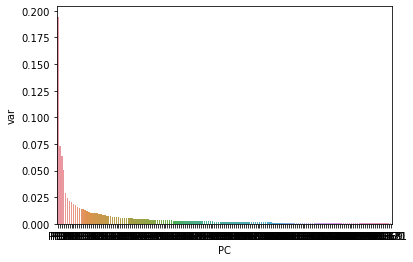

In [13]:
## Dimension Reduction Part 2

pca = PCA(n_components=n)
pca.fit(X_train_selected)
X_train_transformed = pca.transform(X_train_selected)
X_test_transformed = pca.transform(X_test_selected)

cols = []
for i in range(1,n+1):
    cols.append('PC'+str(i))

#Scree plot
scree = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':cols})
sns.barplot(x='PC',y="var", 
           data=scree);

print("Filtered PCA Features")
print(X_train_transformed.shape)

In [14]:
## Classification Models

# Create list of tuples with classifier label and classifier 
classifiers = [("Logistic Regression",LogisticRegression()),
               ("LDA", LinearDiscriminantAnalysis()),
               ("QDA", QuadraticDiscriminantAnalysis()),
               ("Decision Tree",DecisionTreeClassifier()),
               ("ETC", ExtraTreesClassifier()),
               ("Random Forest", RandomForestClassifier()),
               ("Ridge", RidgeClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC())

              ]


In [15]:
## Backtest funciton

def simple_backtest(df,y_train,y_test,y_pred_IS,y_pred_OS,classifier = ""):
    #Quick backtest function to plot the hypothetical returns in IS and OOS. (No transaction fees/market impact included)
    df_backtest = pd.DataFrame(index=y_train.index)
    df_backtest['Open'] = df['Open'].loc[df.index<=pd.to_datetime('2015-01-01')]
    df_backtest['Close'] = df['Close'].loc[df.index<=pd.to_datetime('2015-01-01')]
    df_backtest['next_day_SPY_openclose_ret'] = df_backtest['Close'].shift(-1)/df_backtest['Open'].shift(-1) -1

    df_backtest['signals'] = y_pred_IS
    df_backtest['returns'] = df_backtest['next_day_SPY_openclose_ret'] *df_backtest['signals']
    df_backtest['cumsum'] = df_backtest['returns'].cumsum()
    plt.figure()
    plt.plot(df_backtest['cumsum'])
    plt.title(classifier+' IS Returns')

    df_backtest = pd.DataFrame(index=y_test.index)
    df_backtest['Open'] = df['Open'].loc[df.index>pd.to_datetime('2015-01-01')]
    df_backtest['Close'] = df['Close'].loc[df.index>pd.to_datetime('2015-01-01')]
    df_backtest['next_day_SPY_openclose_ret'] = df_backtest['Close'].shift(-1)/df_backtest['Open'].shift(-1) -1

    df_backtest['signals'] = y_pred_OS
    df_backtest['returns'] = df_backtest['next_day_SPY_openclose_ret'] *df_backtest['signals']
    df_backtest['cumsum'] = df_backtest['returns'].cumsum()
    plt.figure()
    plt.plot(df_backtest['cumsum'])
    plt.title(classifier+ ' OOS Returns')


C:\Users\yizho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression  In-Sample Confusion Matrix
[[ 889  957]
 [ 652 1433]]
Logistic Regression  Out-of-Sample Confusion Matrix
[[ 889  957]
 [ 652 1433]]
LDA  In-Sample Confusion Matrix
[[ 886  960]
 [ 650 1435]]
LDA  Out-of-Sample Confusion Matrix
[[ 886  960]
 [ 650 1435]]
QDA  In-Sample Confusion Matrix
[[1387  459]
 [ 522 1563]]
QDA  Out-of-Sample Confusion Matrix
[[1387  459]
 [ 522 1563]]
Decision Tree  In-Sample Confusion Matrix
[[1846    0]
 [   0 2085]]
Decision Tree  Out-of-Sample Confusion Matrix
[[1846    0]
 [   0 2085]]
ETC  In-Sample Confusion Matrix
[[1846    0]
 [   0 2085]]
ETC  Out-of-Sample Confusion Matrix
[[1846    0]
 [   0 2085]]
Random Forest  In-Sample Confusion Matrix
[[1838    8]
 [  40 2045]]
Random Forest  Out-of-Sample Confusion Matrix
[[1838    8]
 [  40 2045]]
Ridge  In-Sample Confusion Matrix
[[ 886  960]
 [ 649 1436]]
Ridge  Out-of-Sample Confusion Matrix
[[ 886  960]
 [ 649 1436]]
KNN  In-Sample Confusion Matrix
[[1201  645]
 [ 570 1515]]
KNN  Out-of

C:\Users\yizho\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC  In-Sample Confusion Matrix
[[1417  429]
 [ 204 1881]]
SVC  Out-of-Sample Confusion Matrix
[[1417  429]
 [ 204 1881]]
                    Train_Accuracy Test_Accuracy Train_Precision  \
Logistic Regression       0.590689      0.533531        0.599582   
LDA                       0.590435        0.5286        0.599165   
QDA                       0.750445      0.504931        0.772997   
Decision Tree                    1        0.4714               1   
ETC                              1      0.486193               1   
Random Forest             0.987789      0.462525        0.996103   
Ridge                     0.590689      0.529586        0.599332   
KNN                       0.690918      0.513807        0.701389   
SVC                       0.838972      0.527613        0.814286   

                    Test_Precision Train_Recall Test_Recall Train_F1_Score  \
Logistic Regression       0.556818      0.68729    0.708861       0.586209   
LDA                       0.552743     0.

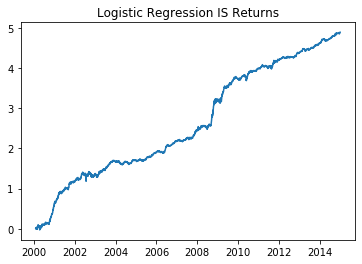

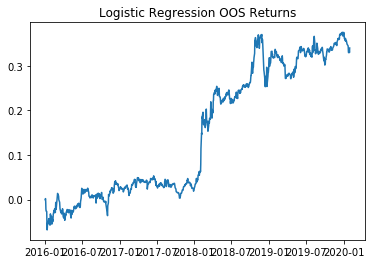

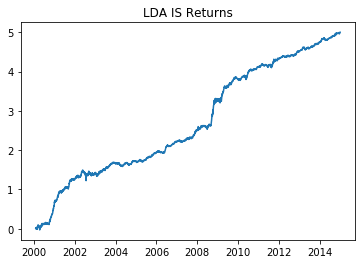

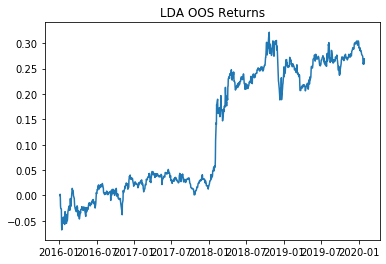

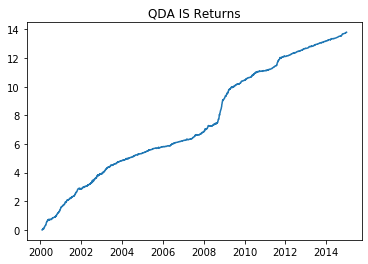

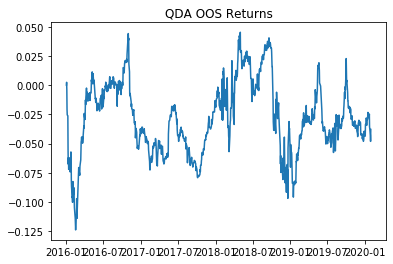

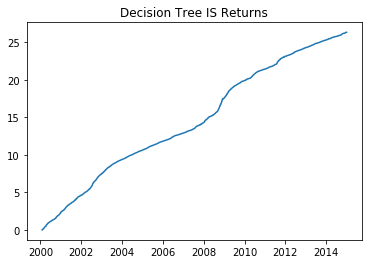

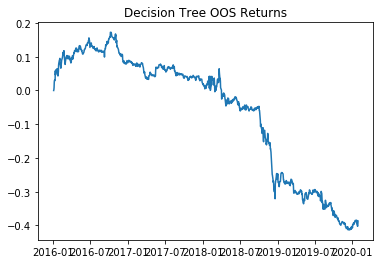

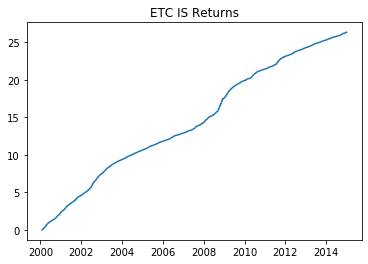

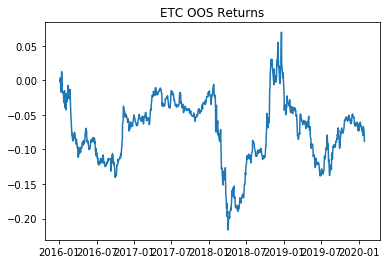

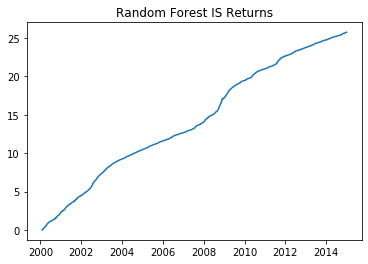

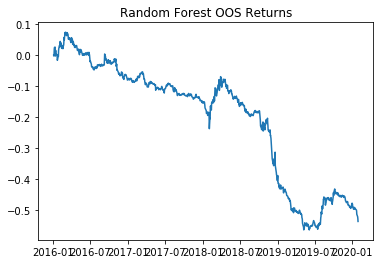

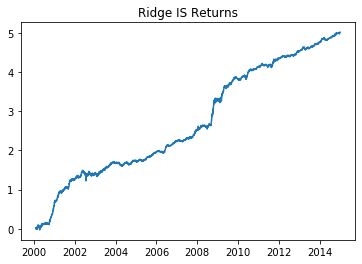

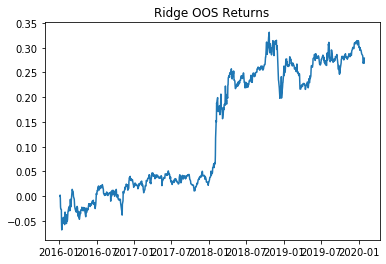

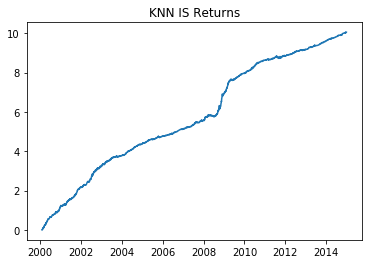

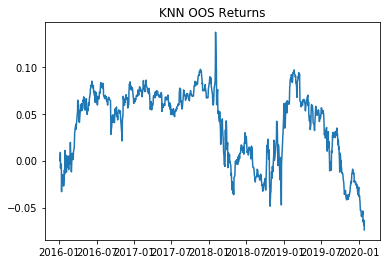

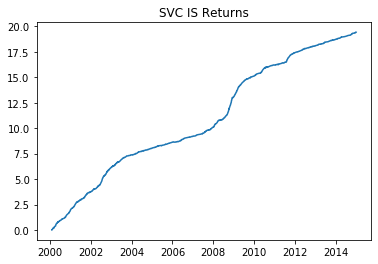

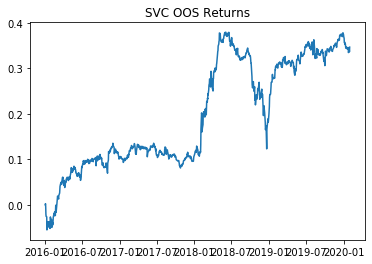

In [19]:
## Results

results = pd.DataFrame(columns=['Train_Accuracy','Test_Accuracy',
                                'Train_Precision','Test_Precision',
                                'Train_Recall','Test_Recall',
                                'Train_F1_Score','Test_F1_Score'],
                       index=["Logistic Regression","LDA","QDA","Decision Tree","ETC","Random Forest","Ridge","KNN","SVC"])

for clf in classifiers: 
    
    #Train Model
    clf[1].fit(X_train_transformed, y_train.values.ravel())
    
    #Predict - IS: In-Sample, OOS: Out-of-Sample
    y_pred_IS = clf[1].predict(X_train_transformed)
    y_pred_OOS = clf[1].predict(X_test_transformed)
    
    #Compute Accuracy
    results['Train_Accuracy'][clf[0]] = metrics.accuracy_score(y_train, y_pred_IS)
    results['Test_Accuracy'][clf[0]] = metrics.accuracy_score(y_test, y_pred_OOS)
    
    #Compute Precision
    results['Train_Precision'][clf[0]] = metrics.precision_score(y_train, y_pred_IS)
    results['Test_Precision'][clf[0]] = metrics.precision_score(y_test, y_pred_OOS)
    
    #Compute Precision
    results['Train_Precision'][clf[0]] = metrics.precision_score(y_train, y_pred_IS)
    results['Test_Precision'][clf[0]] = metrics.precision_score(y_test, y_pred_OOS)
    
    #Compute Recall
    
    results['Train_Recall'][clf[0]] = metrics.recall_score(y_train, y_pred_IS)
    results['Test_Recall'][clf[0]] = metrics.recall_score(y_test, y_pred_OOS)
    
    #Compute F1 Score
    results['Train_F1_Score'][clf[0]] = metrics.f1_score(y_train, y_pred_IS,average='weighted')
    results['Test_F1_Score'][clf[0]] = metrics.f1_score(y_test, y_pred_OOS,average='weighted')
    
    #Confusion Matrix
    print(clf[0]," In-Sample Confusion Matrix")
    print(metrics.confusion_matrix(y_train, y_pred_IS))
    print(clf[0]," Out-of-Sample Confusion Matrix")
    print(metrics.confusion_matrix(y_train, y_pred_IS))
    
    simple_backtest(df,y_train,y_test,y_pred_IS,y_pred_OOS,clf[0])
print(results)   